In [19]:
data_path = 'C:\\Users\\junai\\Documents\\ML Projects\\Stock prediction\Data\\indexProcessed.csv'

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\junai\AppData\Local\Temp\ipykernel_14356\1861861350.py:1: SyntaxWarning: invalid escape sequence '\D'
  data_path = 'C:\\Users\\junai\\Documents\\ML Projects\\Stock prediction\Data\\indexProcessed.csv'


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
df = pd.read_csv(data_path,delimiter=',')


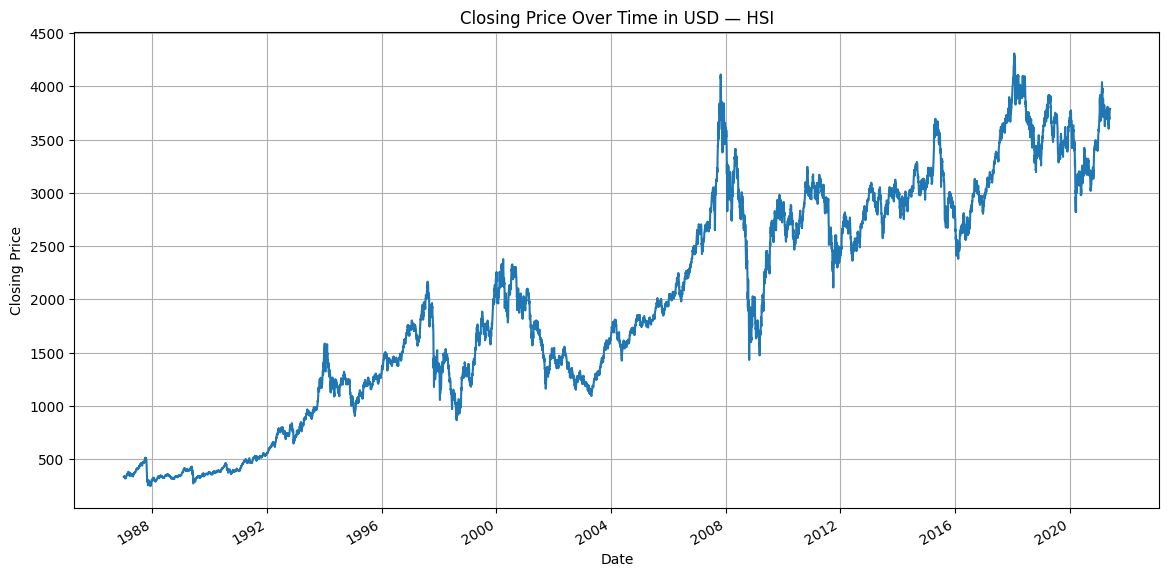

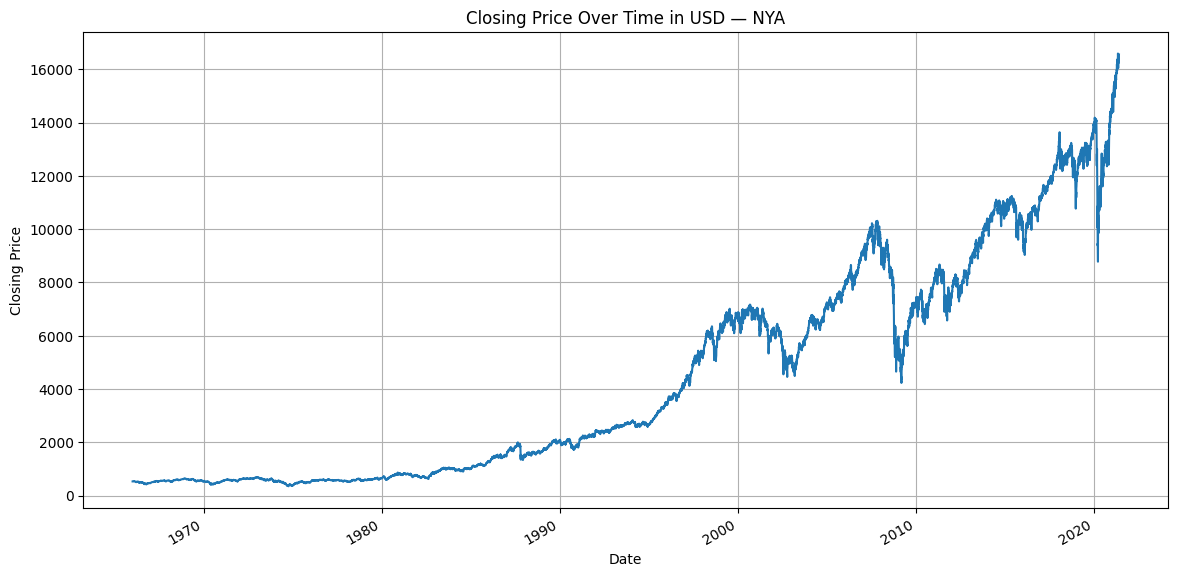

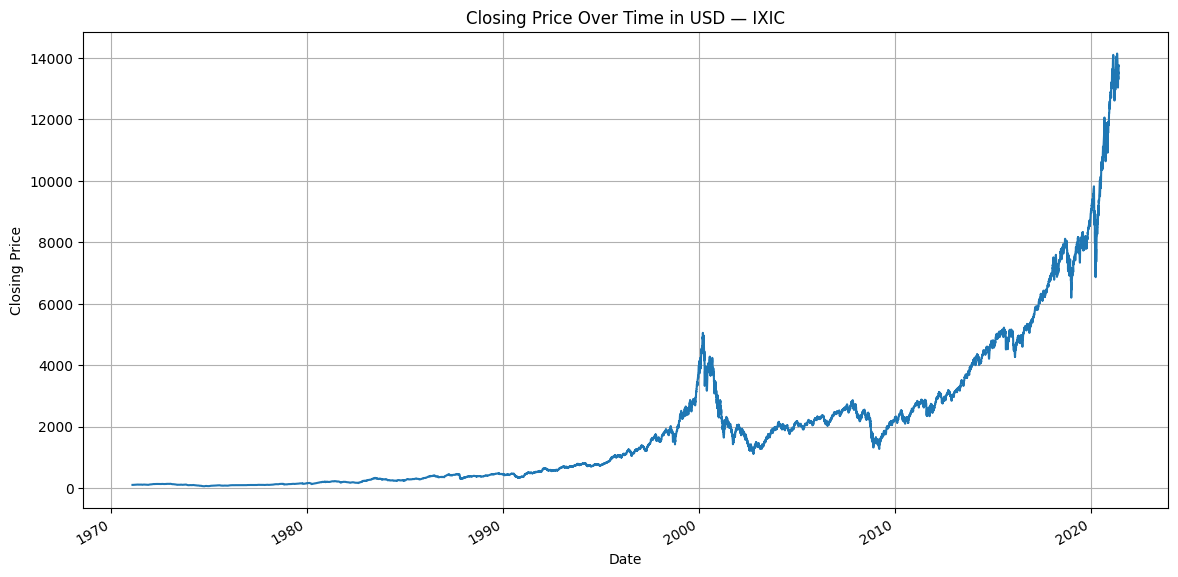

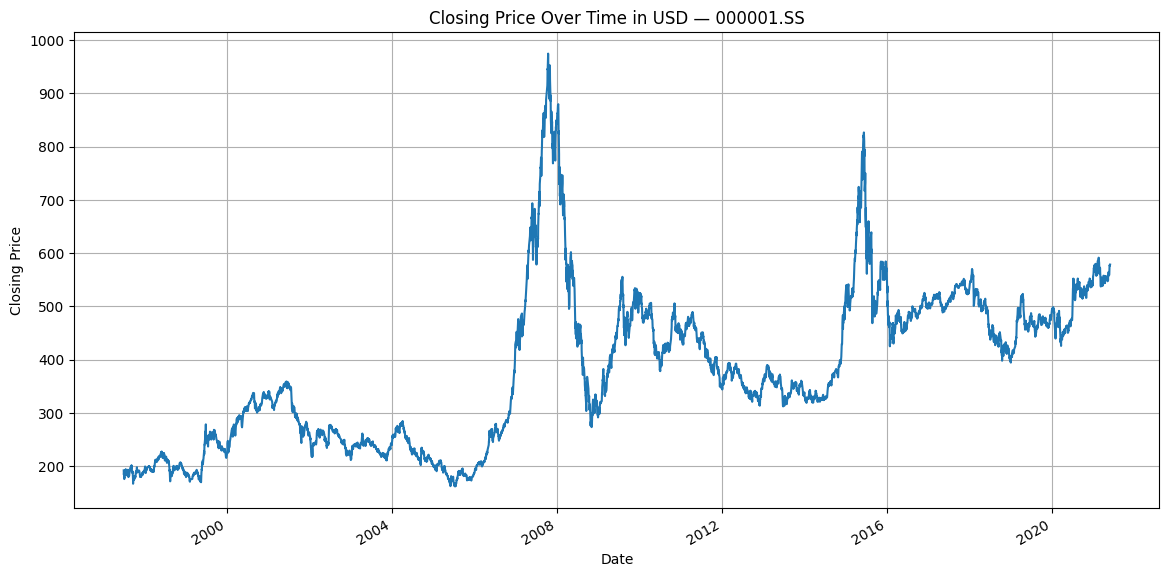

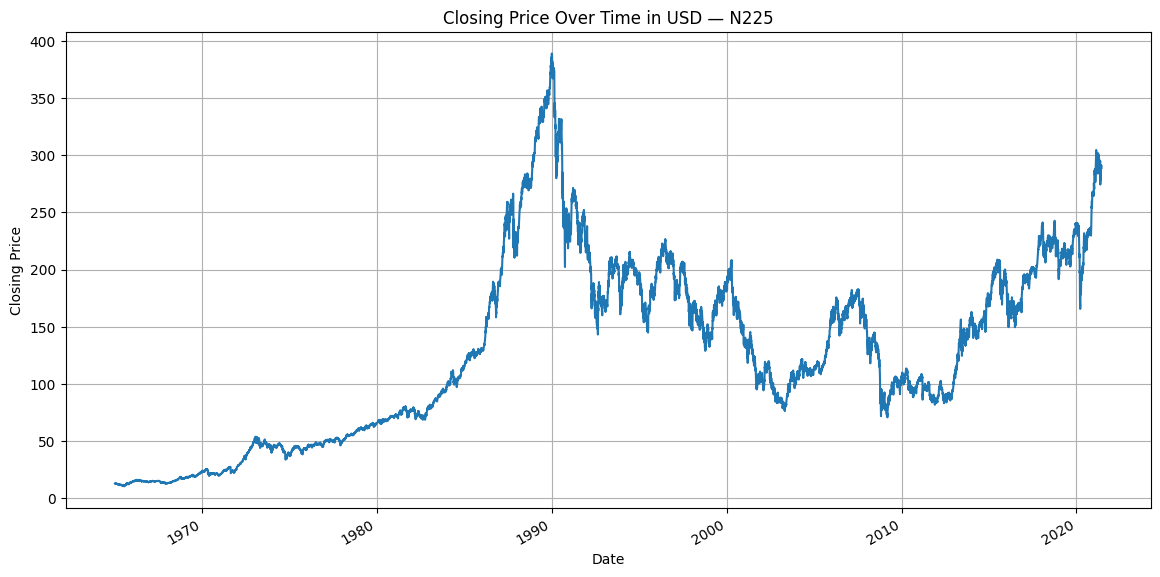

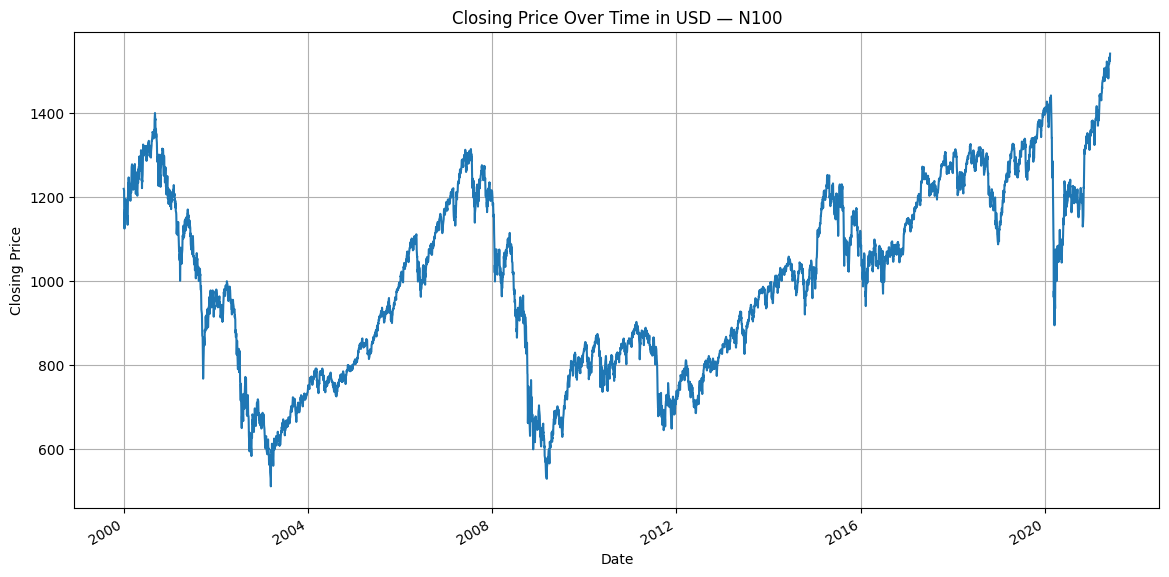

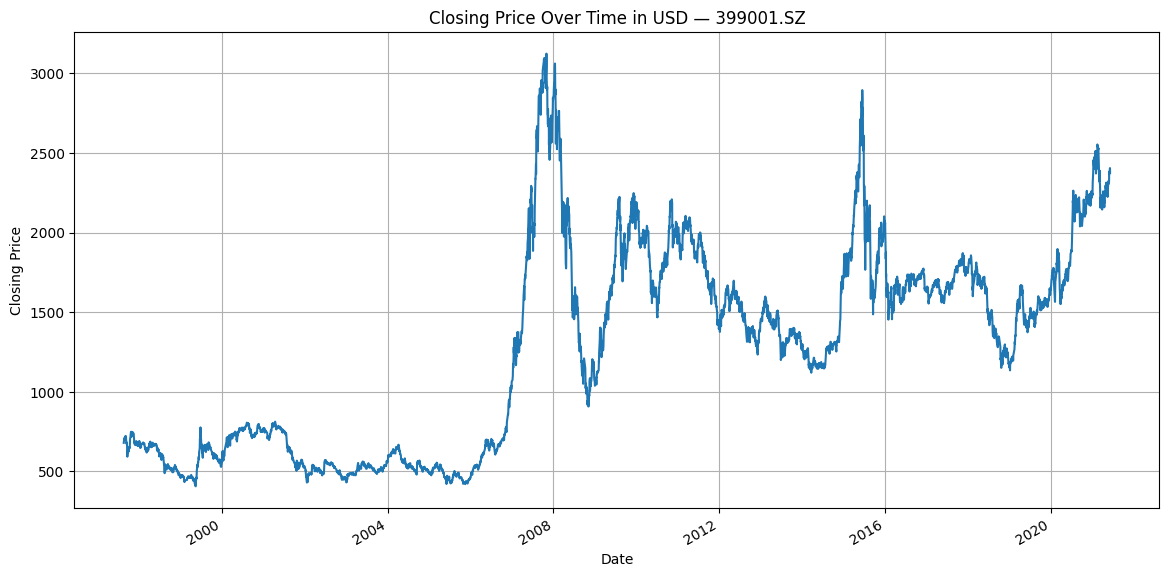

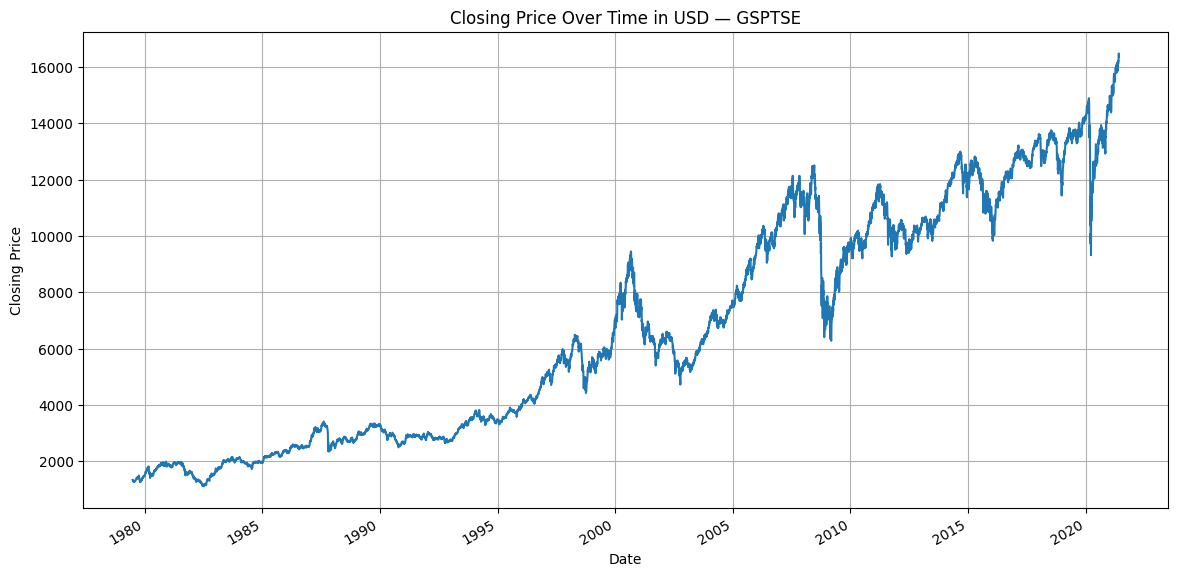

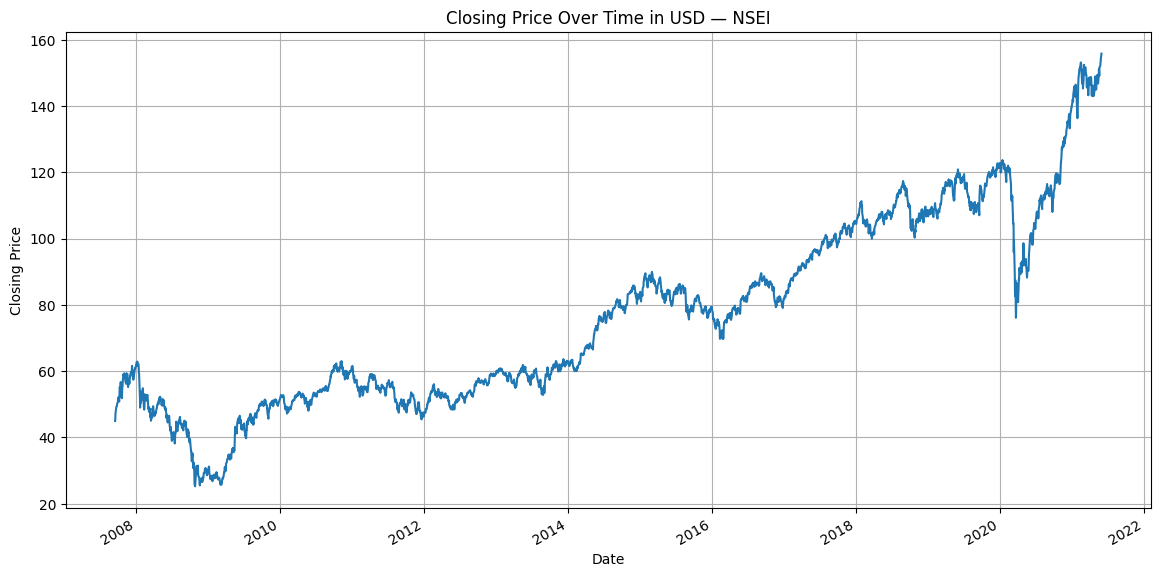

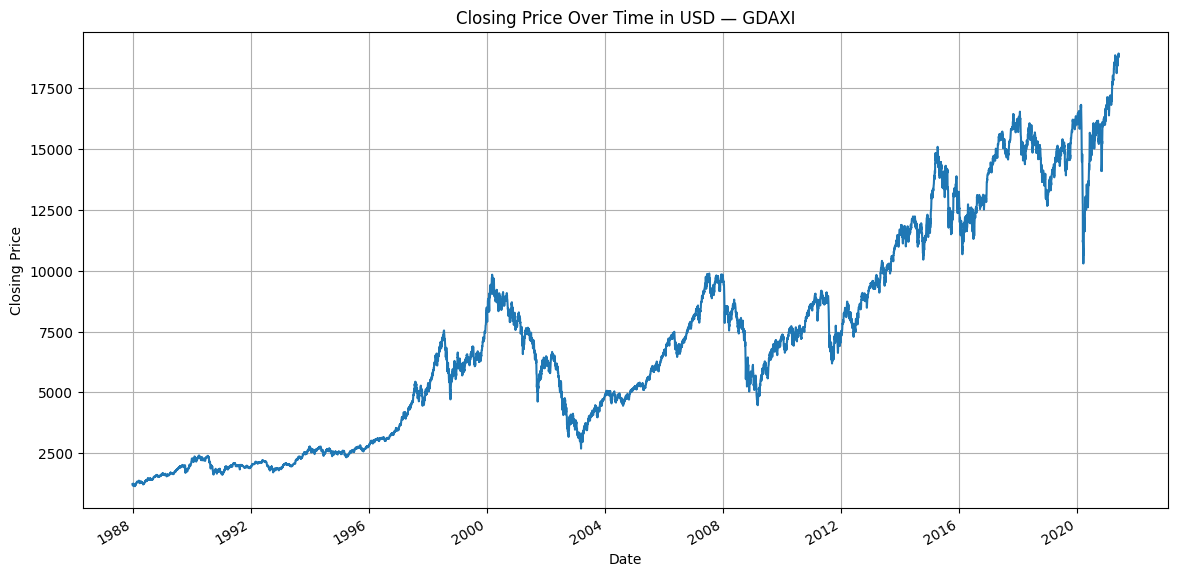

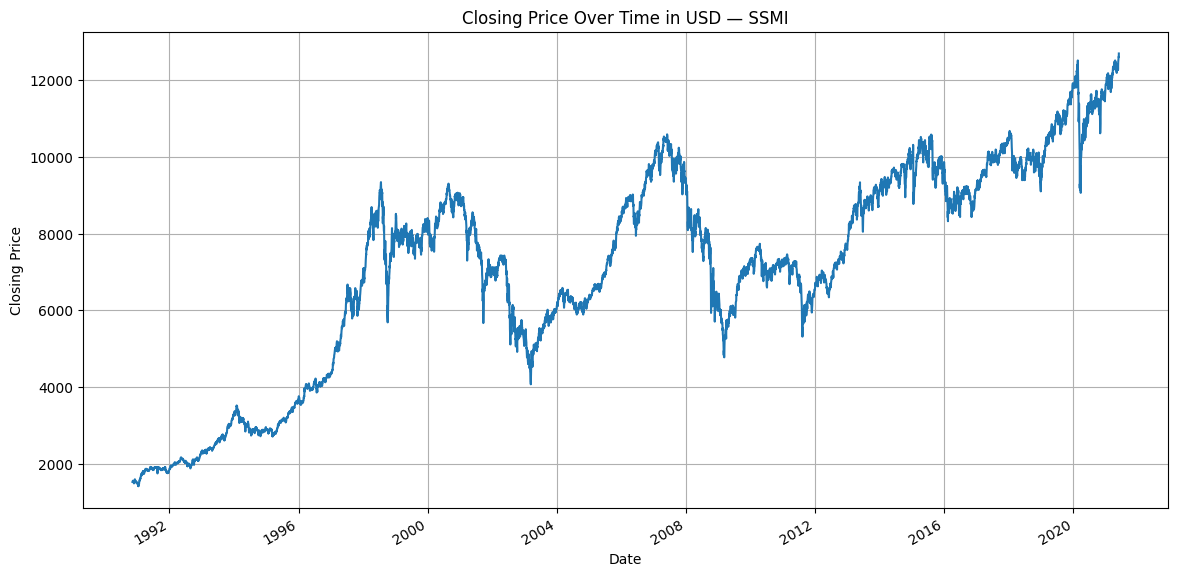

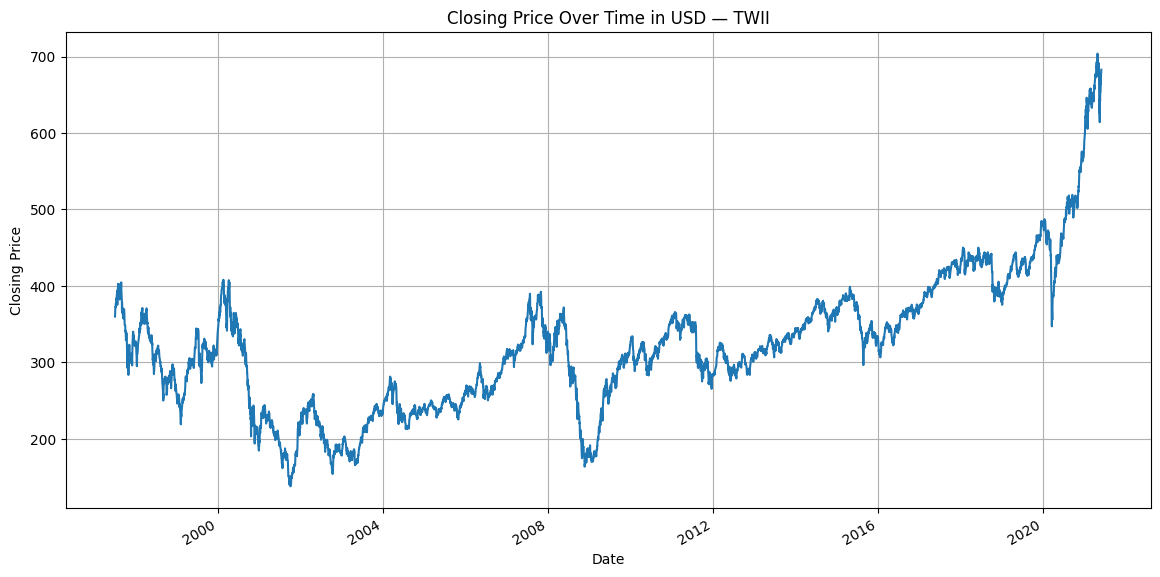

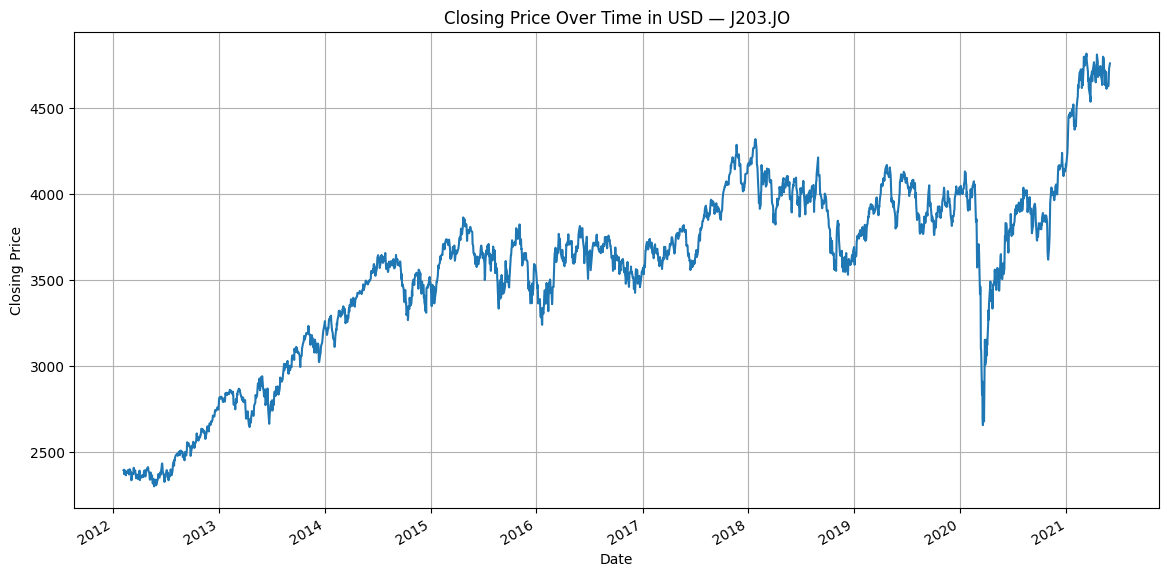

In [3]:



# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Get all unique indices
unique_indices = df['Index'].unique()

# Loop through each index and plot
for index_name in unique_indices:
    filtered_df = df[df['Index'] == index_name].set_index('Date')
    
    if filtered_df.empty:
        continue  # Skip if there's no data

    plt.figure(figsize=(14, 7))
    filtered_df['CloseUSD'].plot()
    plt.title(f'Closing Price Over Time in USD — {index_name}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.grid(True)
    plt.show()




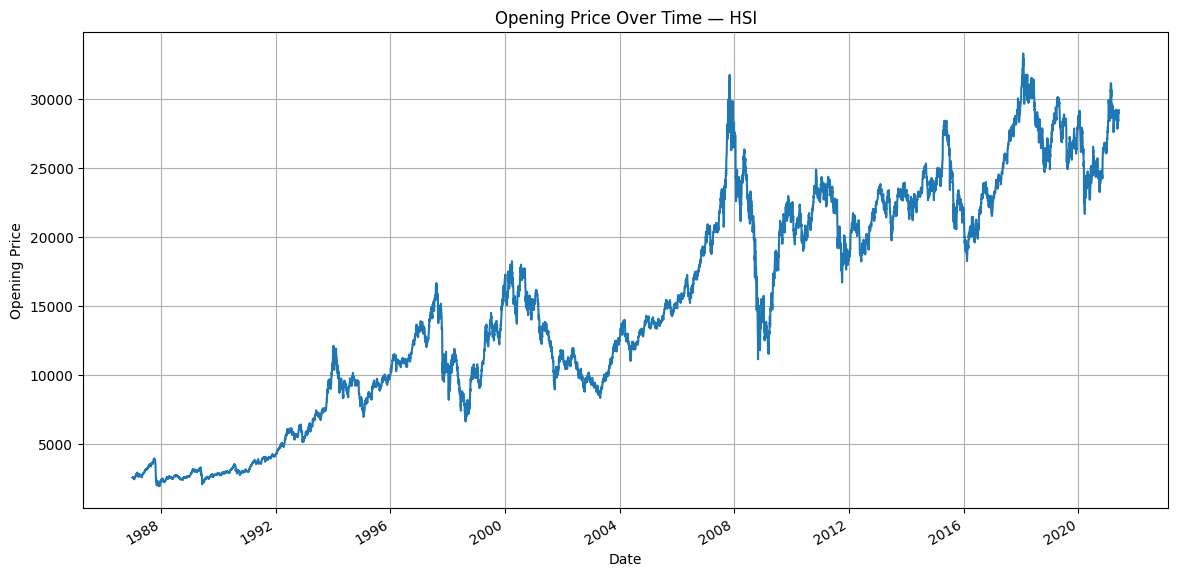

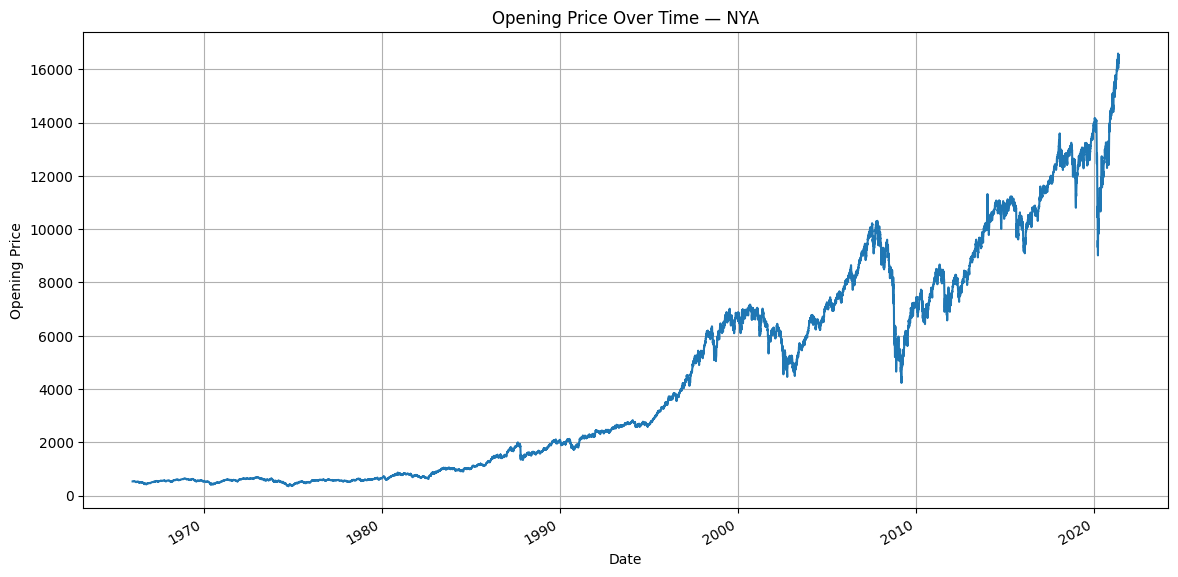

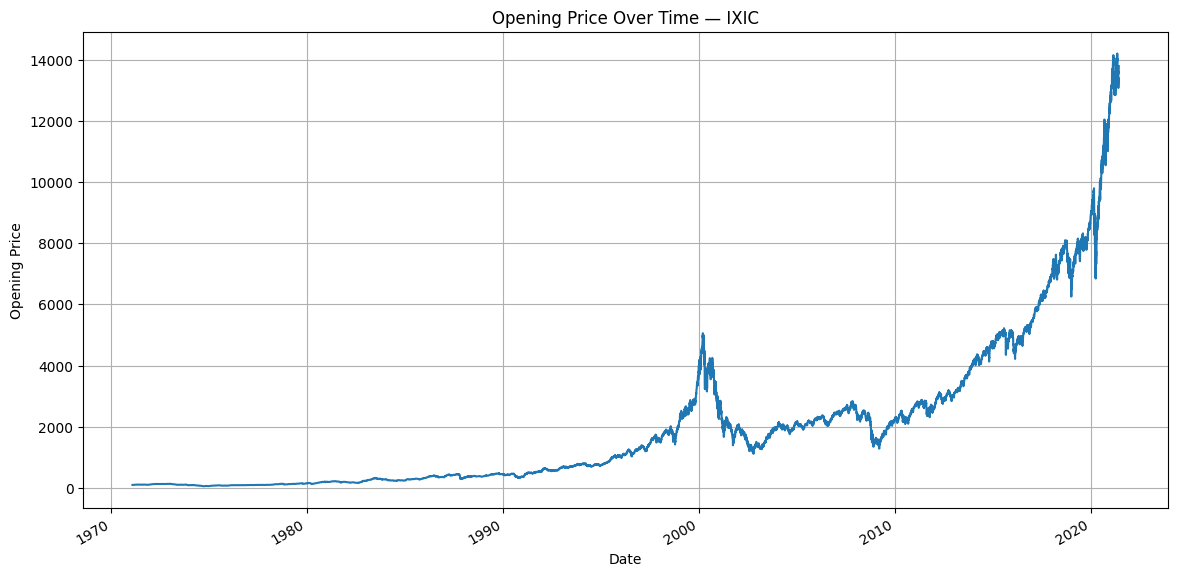

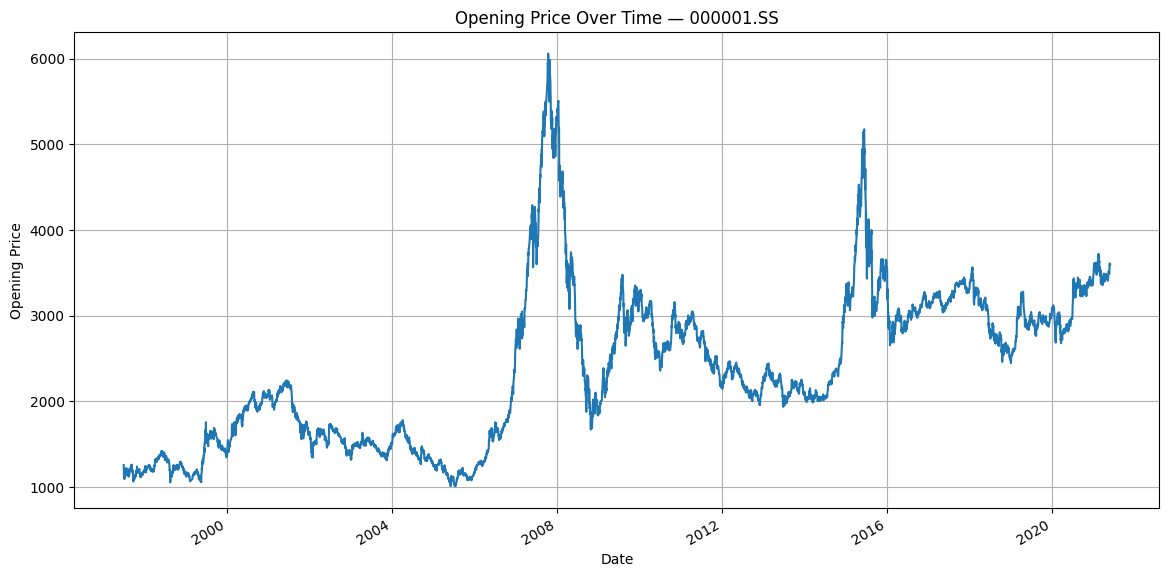

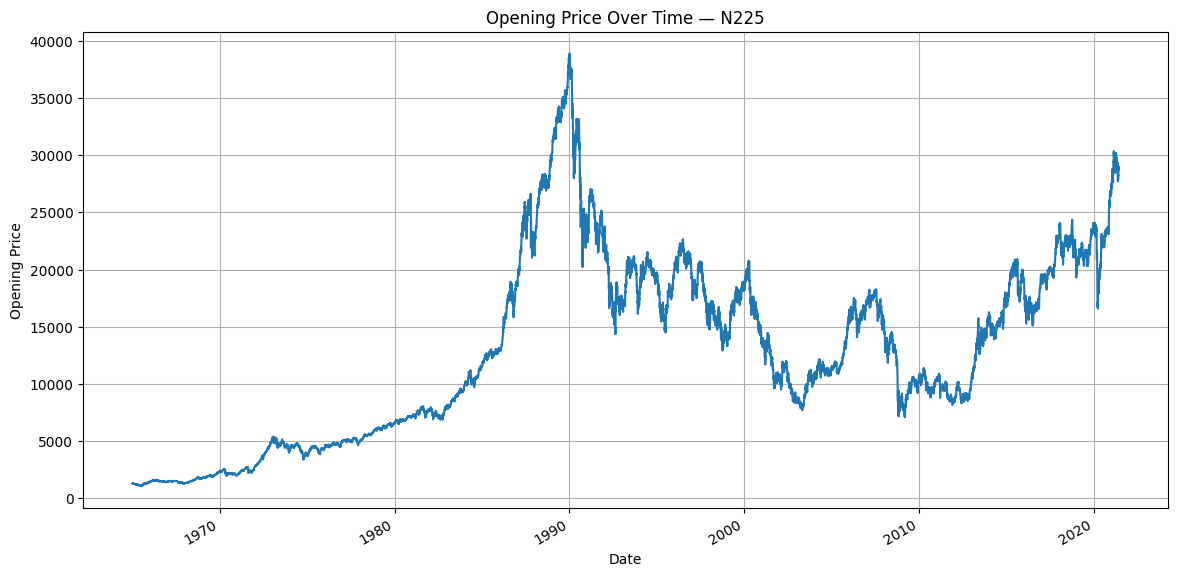

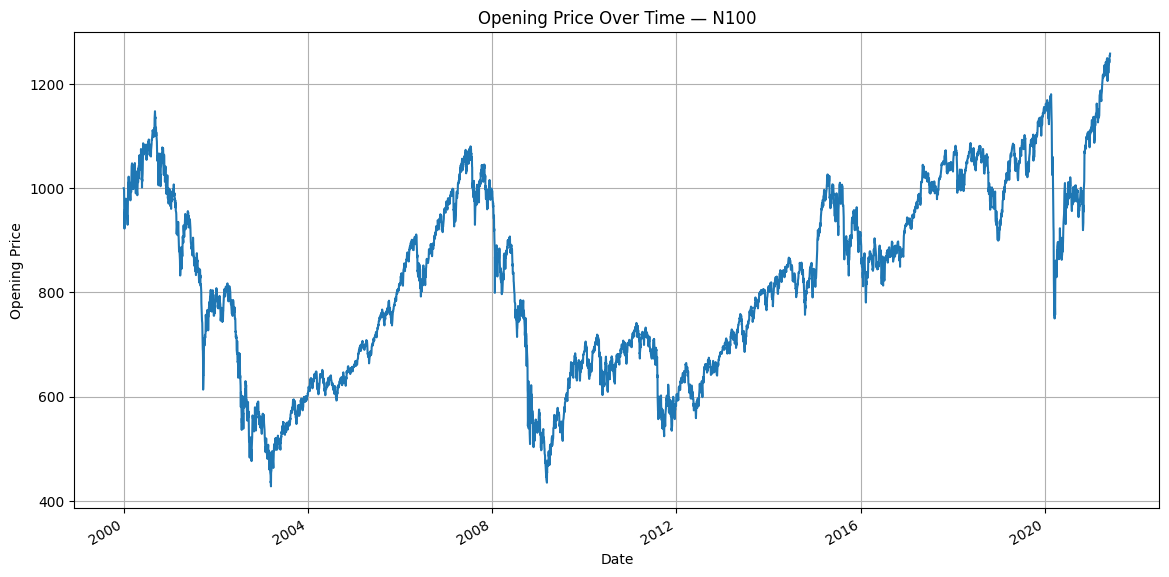

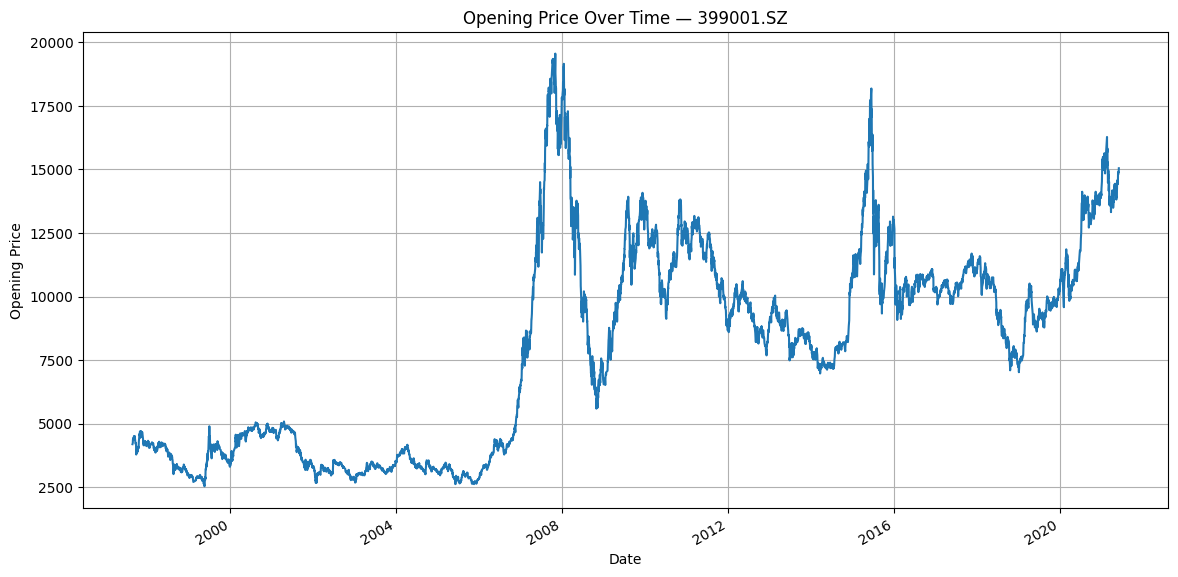

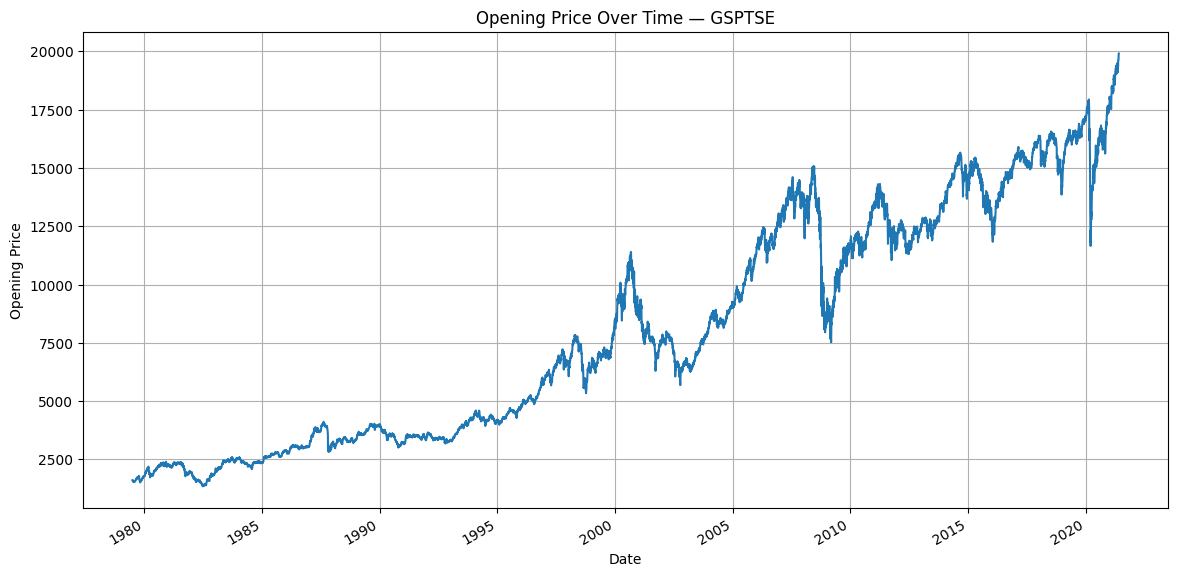

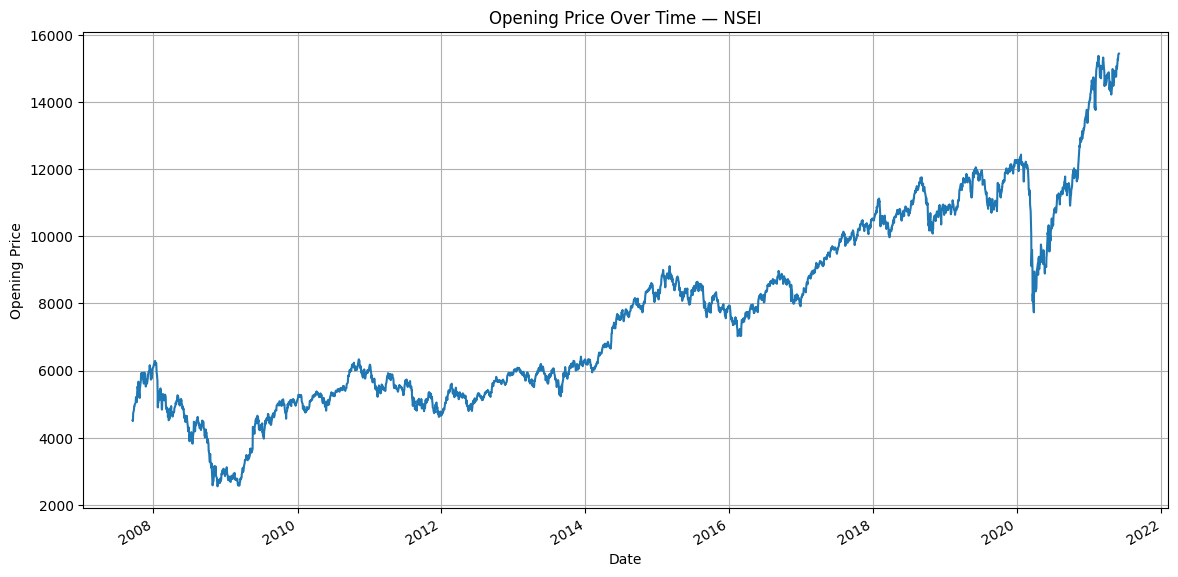

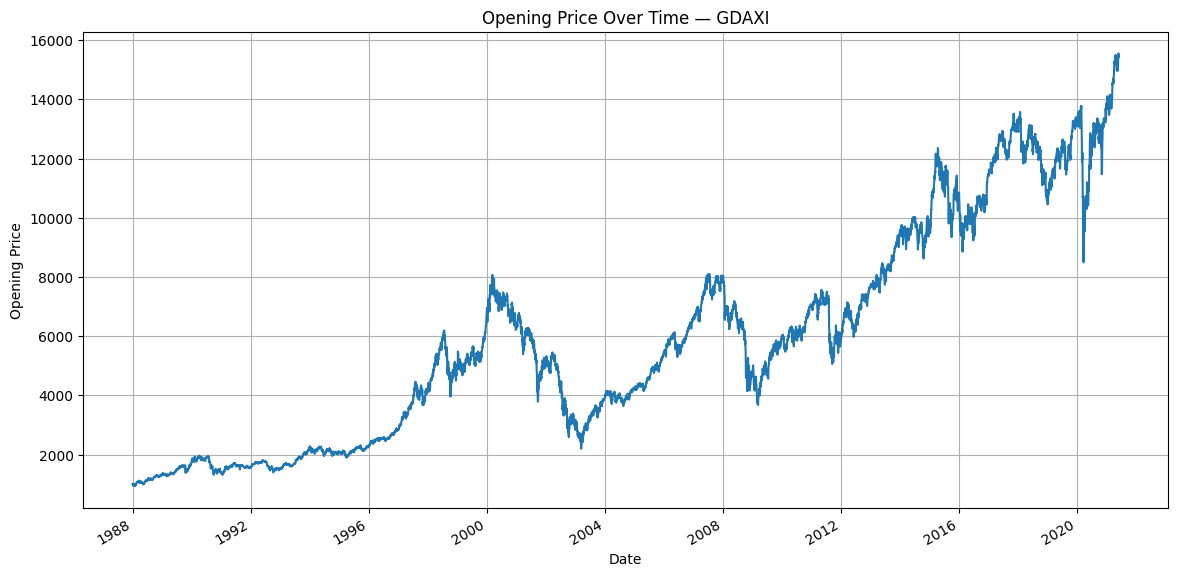

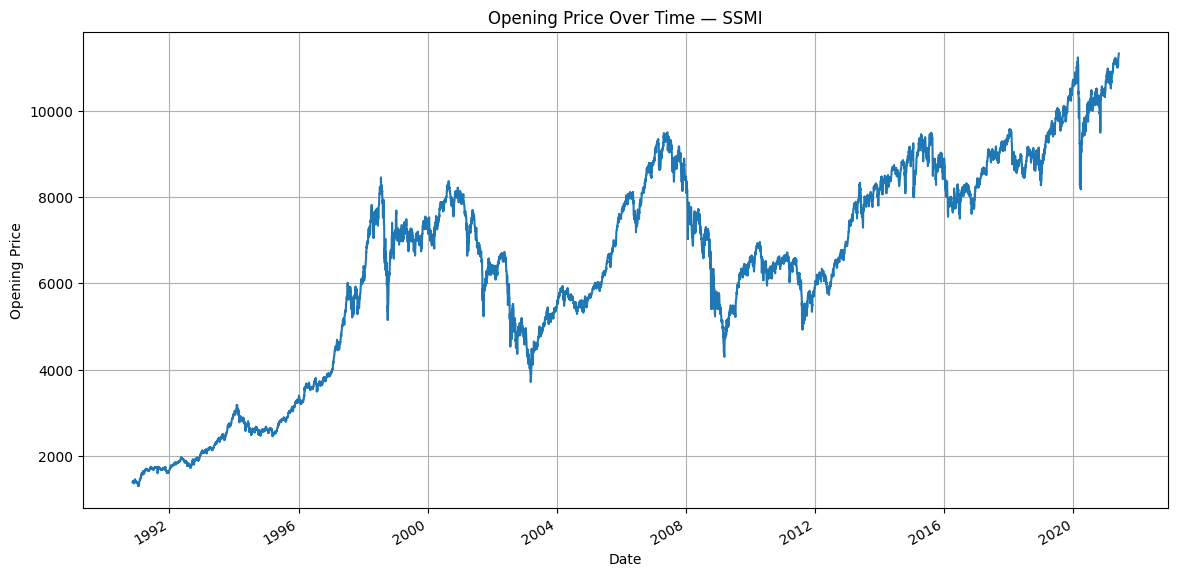

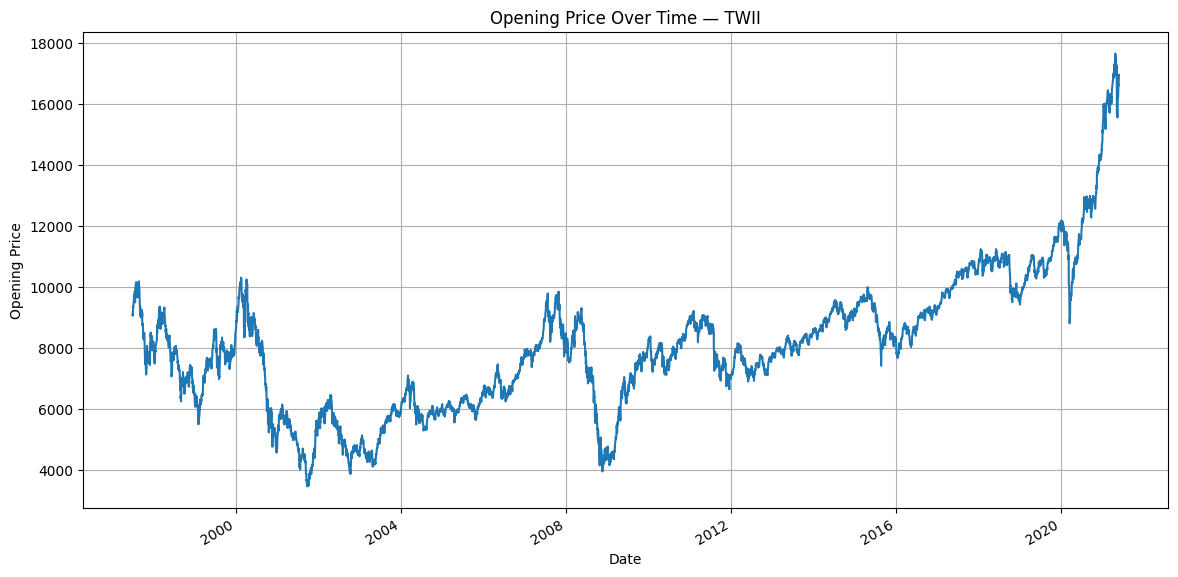

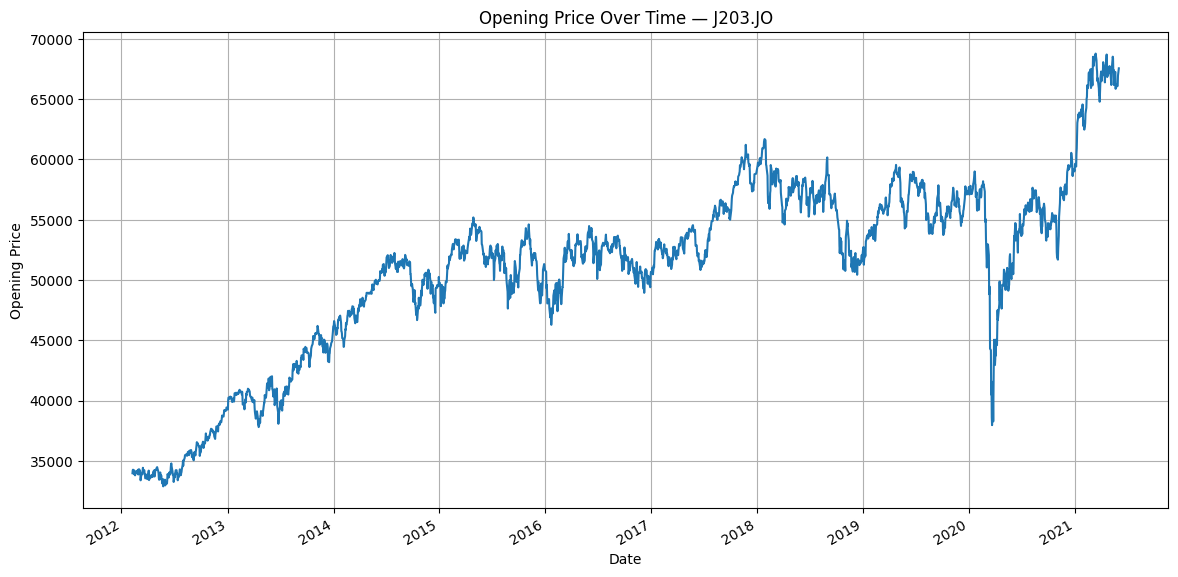

In [4]:
# Plots for the opening price of all indexes.
for index_name in unique_indices:
    filtered_df = df[df['Index'] == index_name].set_index('Date')
    
    if filtered_df.empty:
        continue  # Skip if there's no data

    plt.figure(figsize=(14, 7))
    filtered_df['Open'].plot()
    plt.title(f'Opening Price Over Time — {index_name}')
    plt.xlabel('Date')
    plt.ylabel('Opening Price')
    plt.grid(True)
    plt.show()


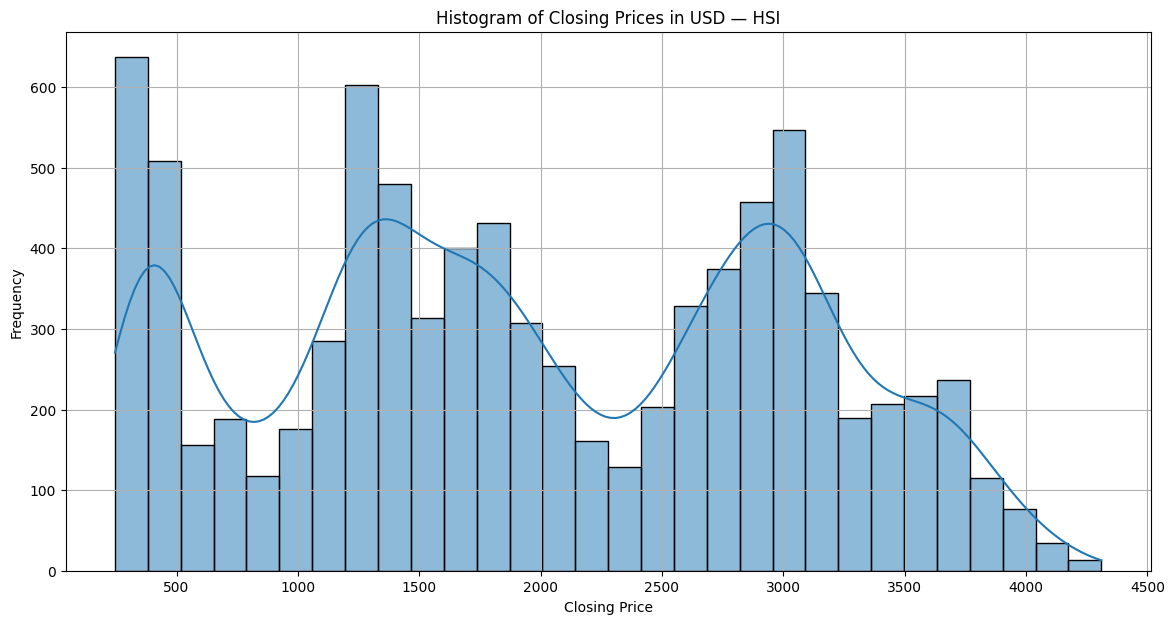

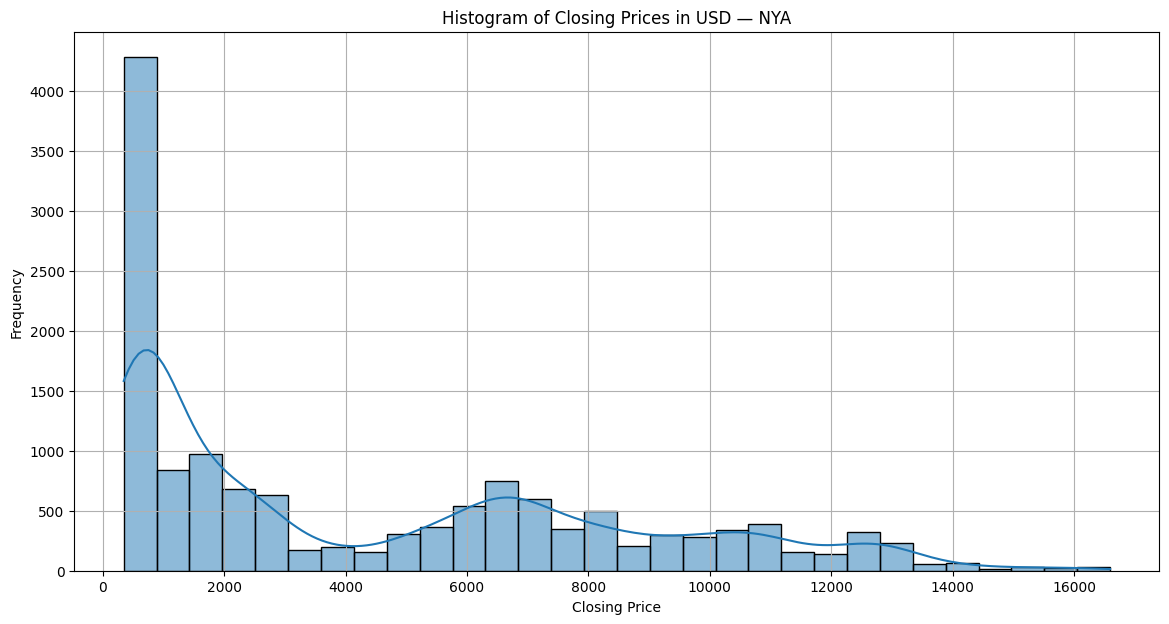

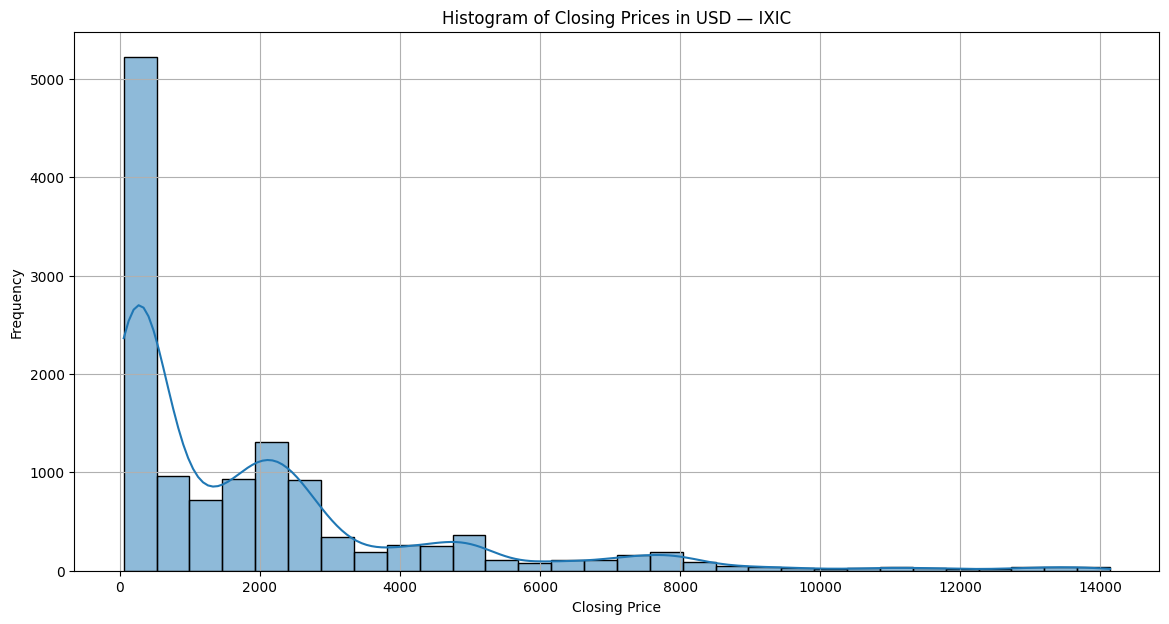

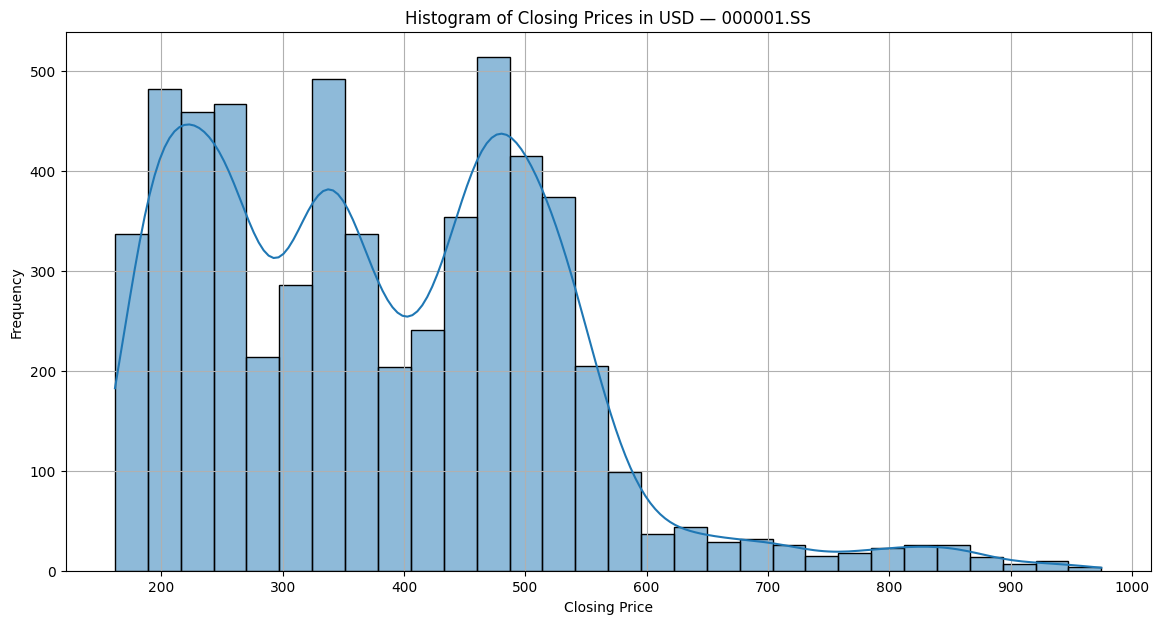

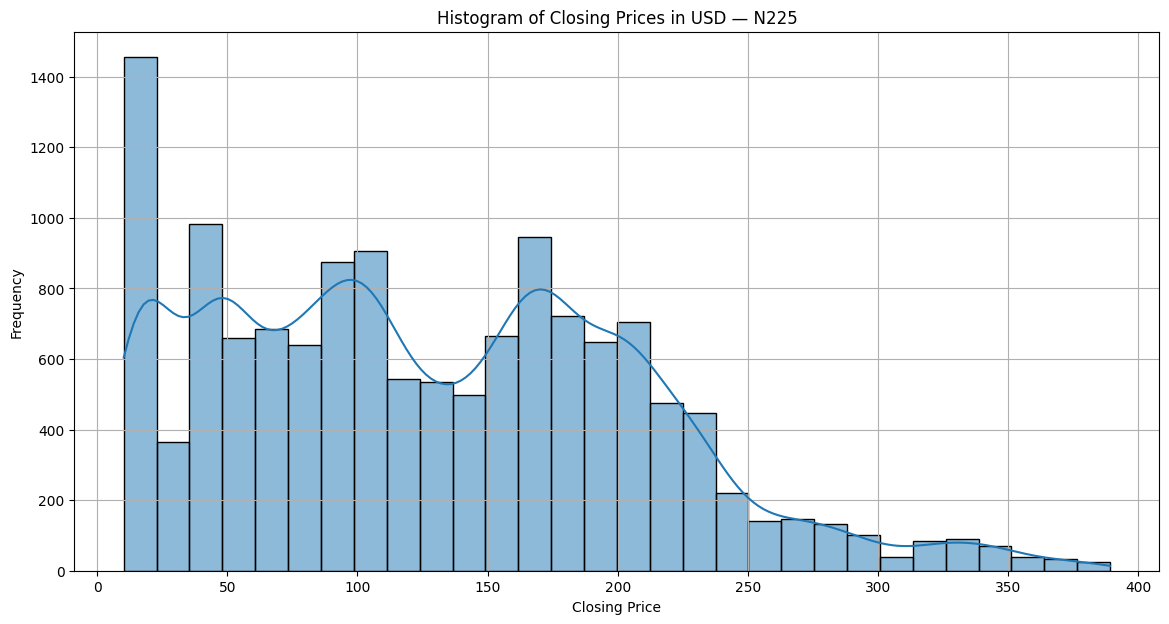

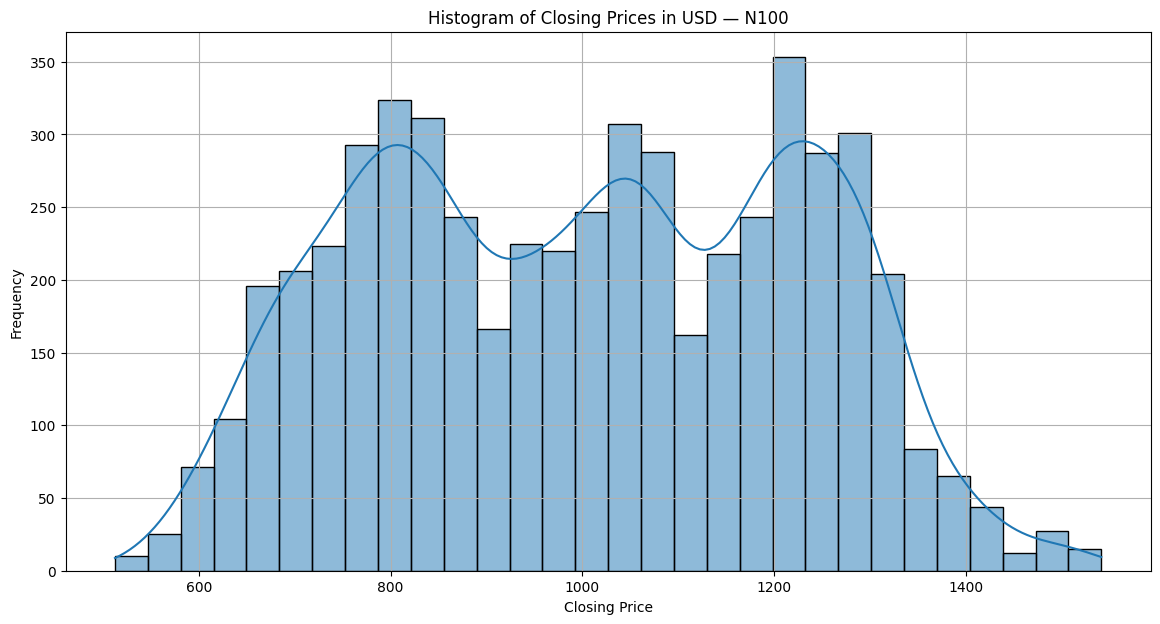

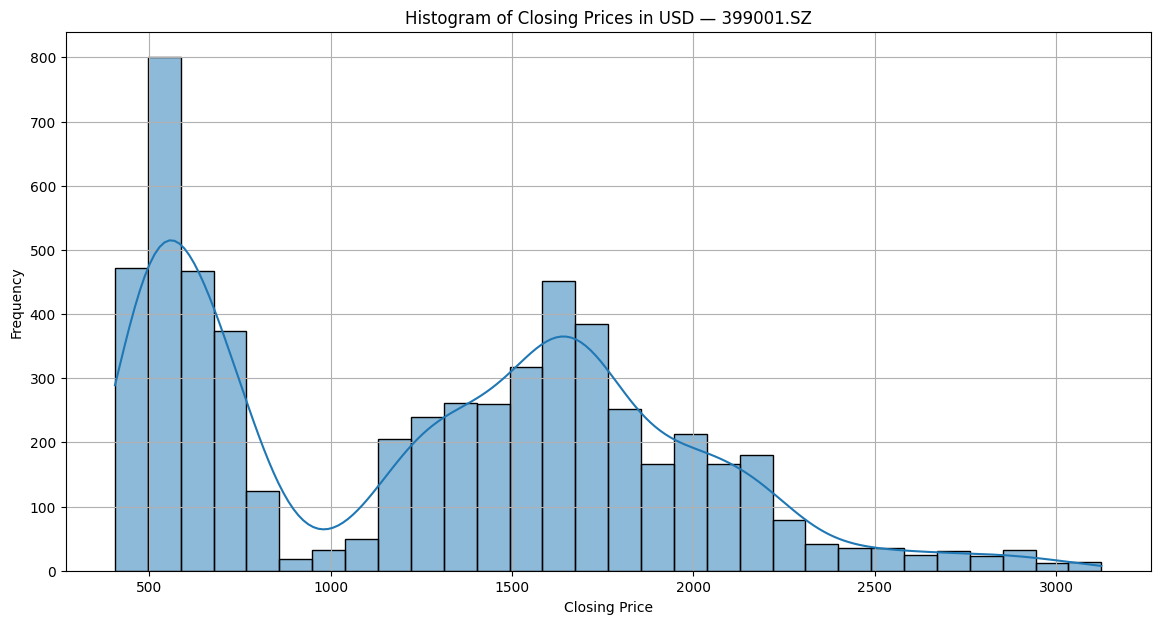

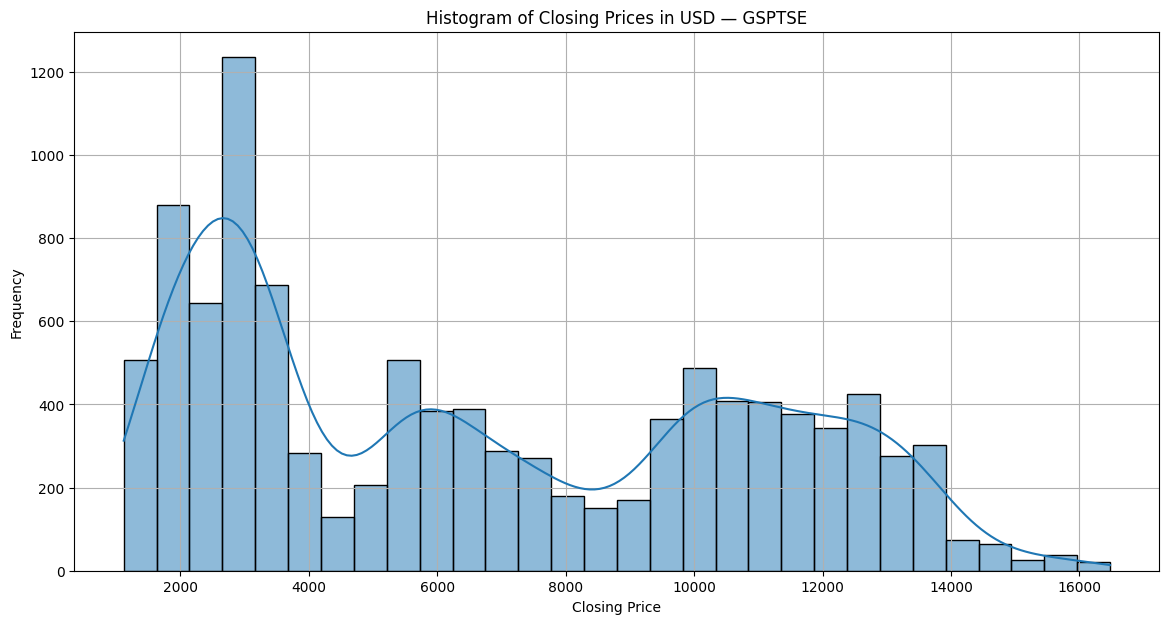

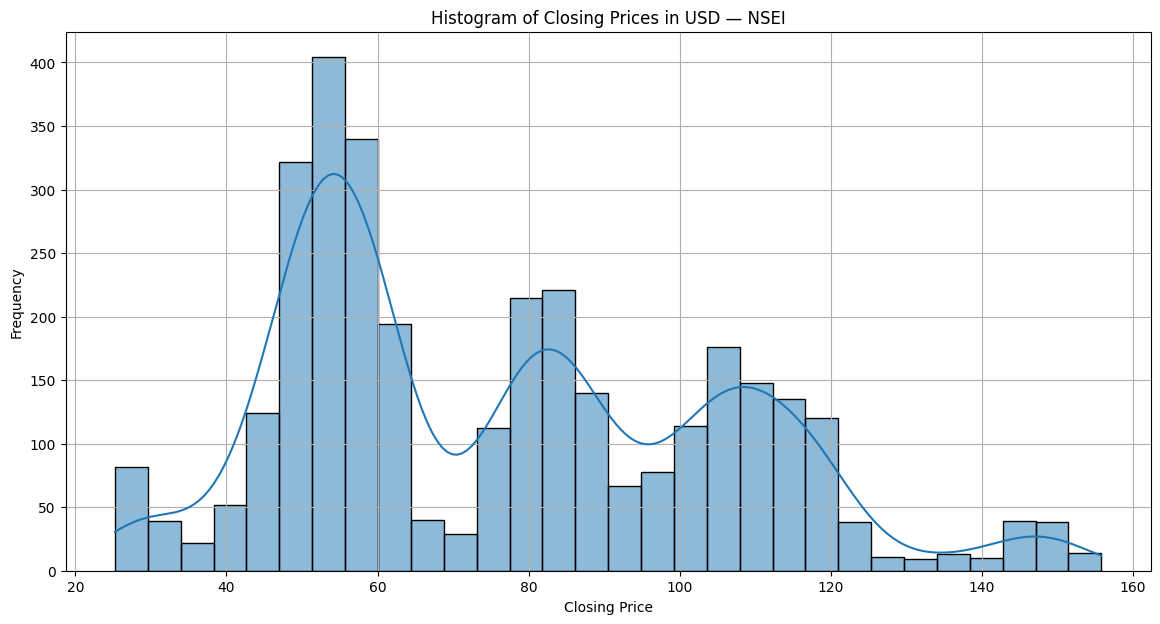

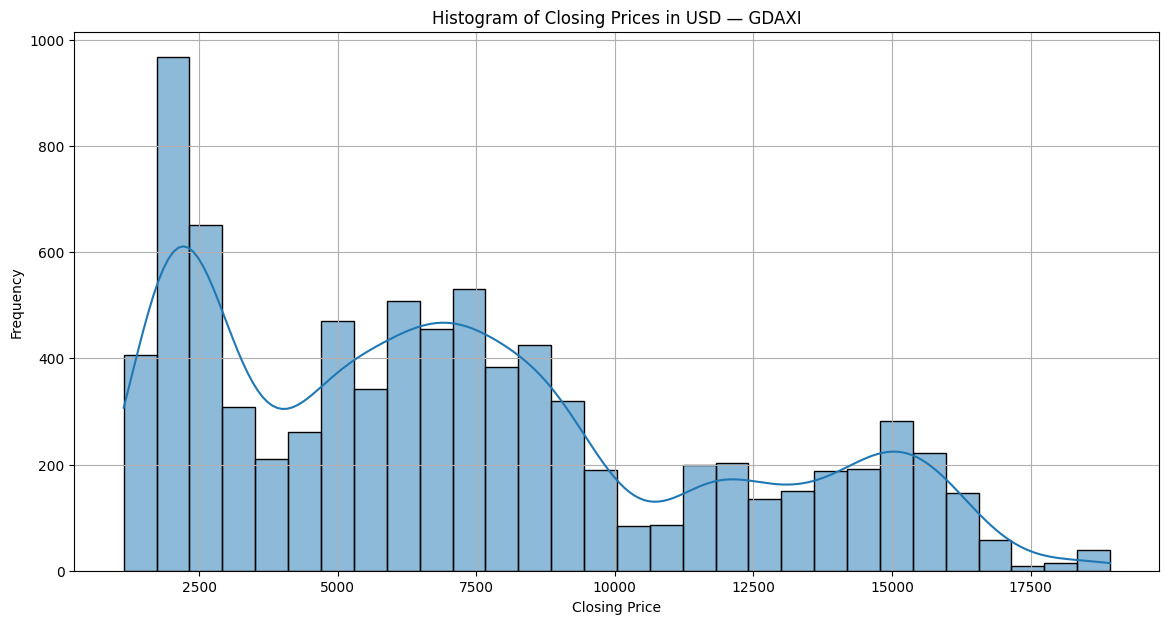

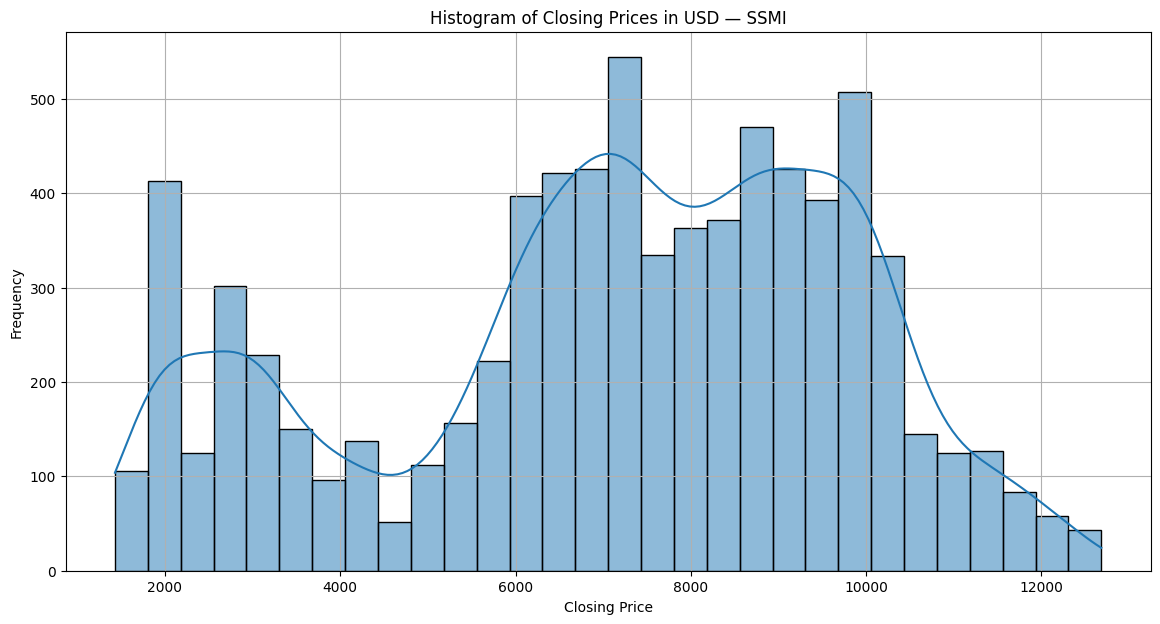

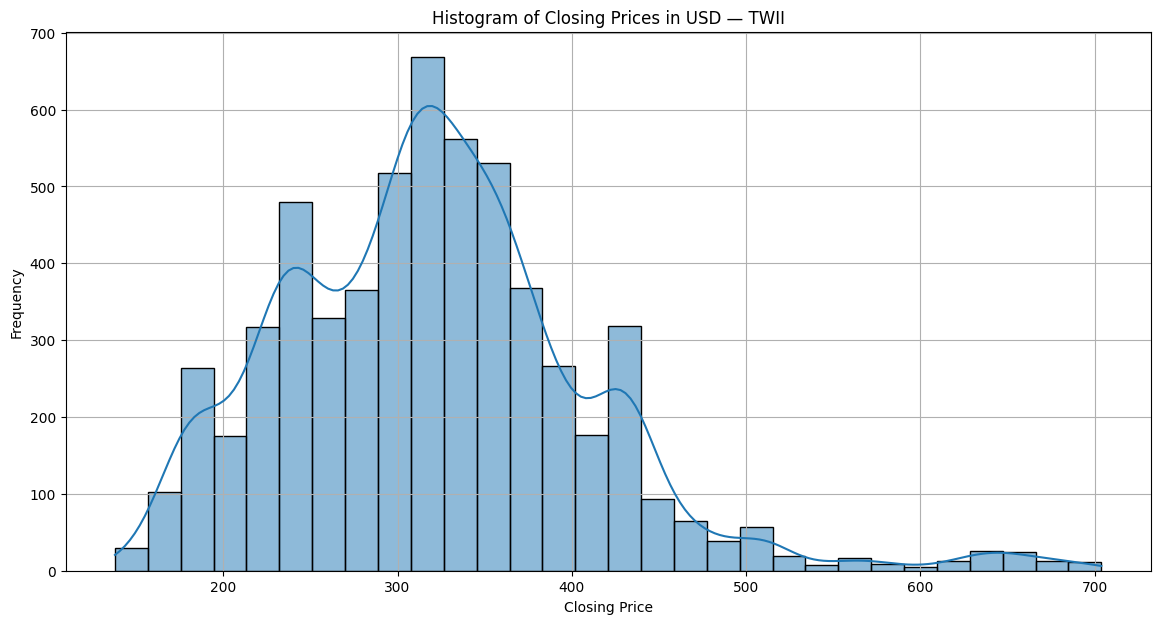

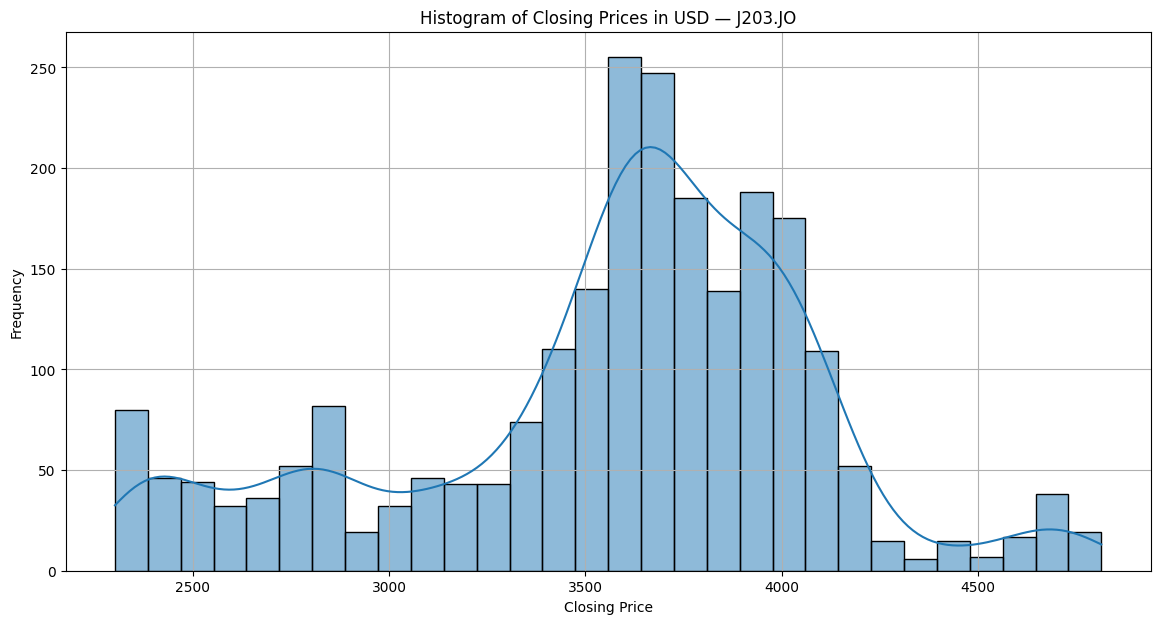

In [5]:
# histogram for all indexes 
for index_name in unique_indices:
    filtered_df = df[df['Index'] == index_name]
    
    if filtered_df.empty:
        continue  # Skip if there's no data

    plt.figure(figsize=(14, 7))
    sns.histplot(filtered_df['CloseUSD'], bins=30, kde=True)
    plt.title(f'Histogram of Closing Prices in USD — {index_name}')
    plt.xlabel('Closing Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# outliers detection in closing price in usd for every index
for index_name in unique_indices:
    filtered_df = df[df['Index'] == index_name]
    
    if filtered_df.empty:
        continue  # Skip if there's no data

    plt.figure(figsize=(14, 7))
    sns.boxplot(x=filtered_df['CloseUSD'])
    plt.title(f'Box Plot of Closing Prices in USD — {index_name}')
    plt.xlabel('Closing Price')
    plt.grid(True)
    plt.show()
    


Index(['Index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD'],
      dtype='object')


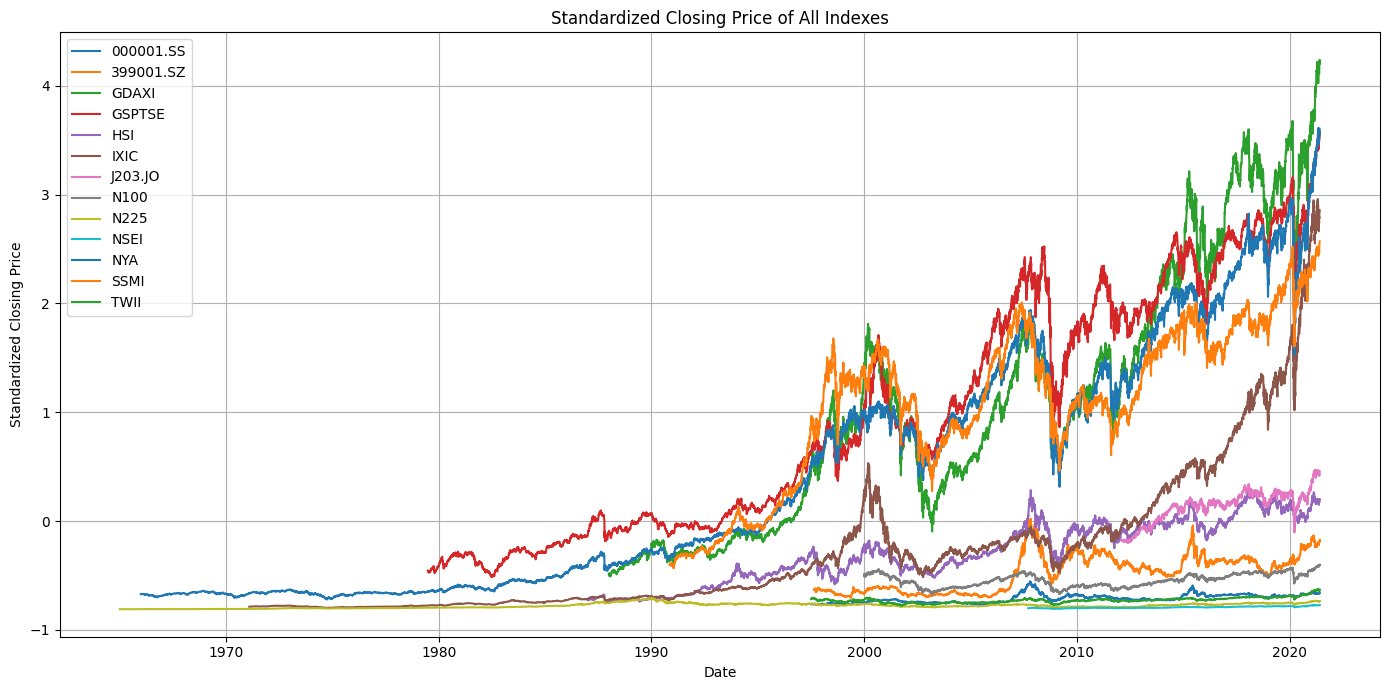

In [21]:
from sklearn.preprocessing import StandardScaler

# # Extracting the HSI index
# HSI_data = df[df['Index'] == 'HSI'].set_index('Date')
# # Standardizing the 'CloseUSD' column
# scaler = StandardScaler()
# HSI_data['CloseUSD_scaled'] = scaler.fit_transform(HSI_data[['CloseUSD']])

# Extraction of the all indexes

df['Date'] = pd.to_datetime(df['Date'])
print(df.columns)
df.set_index('Date', inplace=True)
# Standardizing the 'CloseUSD' column for all indexes
scaler = StandardScaler()
Scaled_data = scaler.fit_transform(df[['CloseUSD']])
df['CloseUSD_scaled'] = Scaled_data
# plotting the standardized closing price of all indexes with every index having its own color


plt.figure(figsize=(14, 7))

# Group by 'Index' and plot each with its own color
for index_name, group in df.groupby('Index'):
    plt.plot(group.index, group['CloseUSD_scaled'], label=index_name)

plt.title('Standardized Closing Price of All Indexes')
plt.xlabel('Date')
plt.ylabel('Standardized Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()







In [22]:
from sklearn.model_selection import train_test_split


# Sliding window function for 1D scaled data
def create_sliding_window_data(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].values)
        y.append(df.iloc[i + window_size][0])  # single-column DataFrame
    return np.array(X), np.array(y)

# Create features and labels
window_size = 50
X, y = create_sliding_window_data(df[['CloseUSD_scaled']], window_size)

# Split train-test without shuffling (important for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")





C:\Users\junai\AppData\Local\Temp\ipykernel_14356\1658012495.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(df.iloc[i + window_size][0])  # single-column DataFrame


X_train shape: (83339, 50, 1), y_train shape: (83339,)
X_test shape: (20835, 50, 1), y_test shape: (20835,)


In [24]:
# LSTM model for time series prediction
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Optional: mixed precision if on GPU
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

model = Sequential()
model.add(LSTM(units=32, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # dtype='float32' if using mixed precision

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=10,                   # Reduced from 20
    batch_size=64,              # Increased from 32
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)







Epoch 1/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 85s 61ms/step - loss: 0.0863 - val_loss: 0.0120
Epoch 2/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 3/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - loss: 0.0027 - val_loss: 0.0078
Epoch 4/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 100s 76ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 5/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 98s 75ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 6/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 98s 75ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 7/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 98s 75ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 8/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 97s 75ms/step - loss: 0.0012 - val_loss: 0.0084
Epoch 9/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 98s 75ms/step - loss: 0.0016 - val_loss: 0.0060


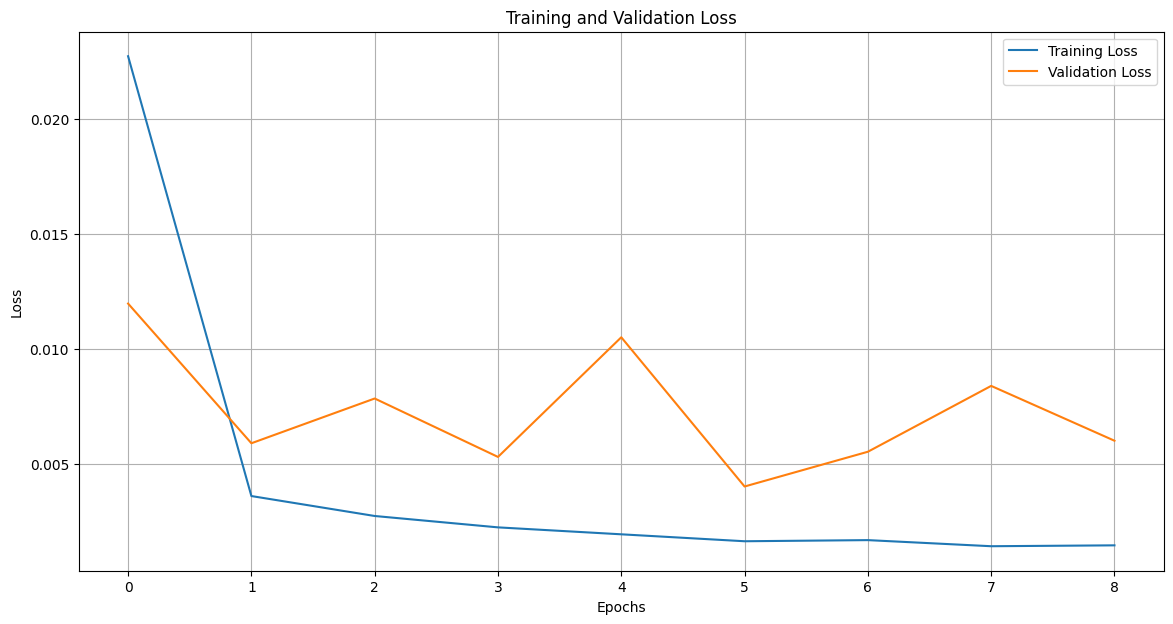

652/652 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0049
Test Loss: 0.004014848731458187
652/652 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step


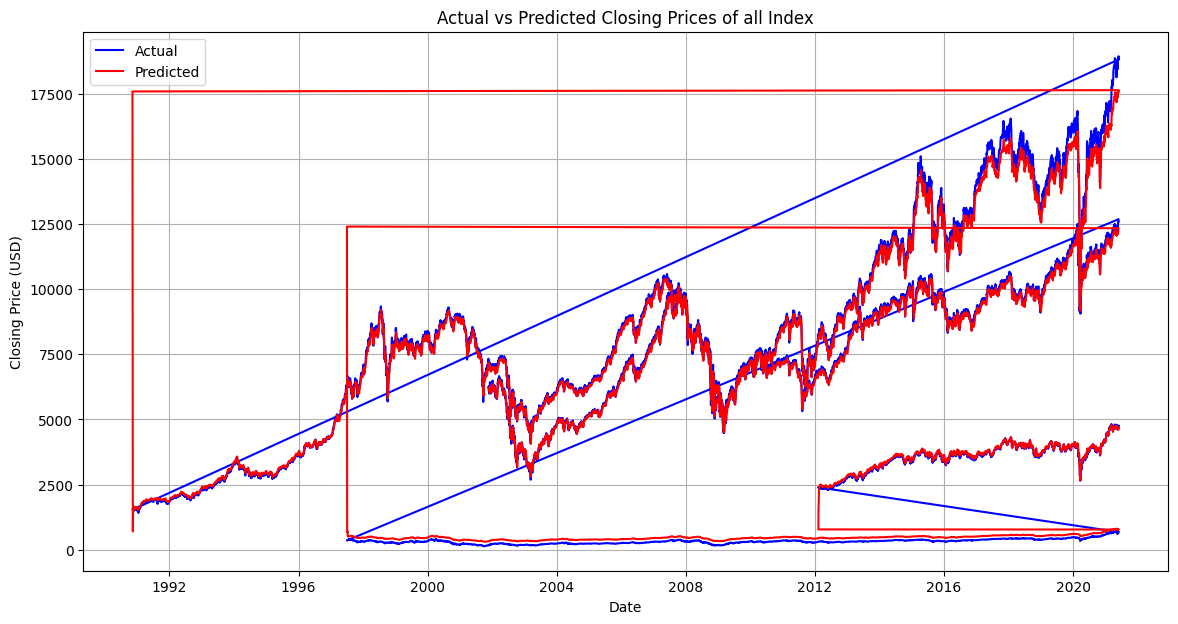

In [26]:
# Plot training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.grid(True)
plt.show()
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
# Make predictions
predictions = model.predict(X_test)
# Inverse transform the predictions to original scale
predictions = scaler.inverse_transform(predictions)
# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='blue')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Closing Prices of all Index')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
# Save the model
model.save('hsi_lstm_model.h5')